# Runtime Test with Burger's eqation with 20% noise.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz

import pysindy as ps
import time as tm

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

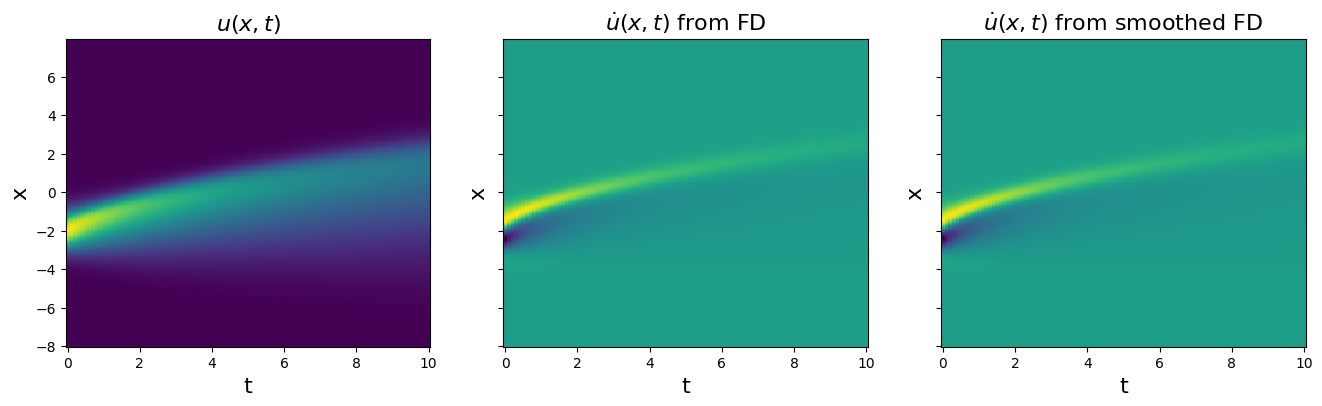

In [2]:
data = loadmat('data/burgers.mat')
time = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
# u = u + np.random.normal(0, rmse / 5.0, u.shape)
# u = u + np.random.normal(0, rmse / 5.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from FD', fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from smoothed FD', fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [3]:
# Define form PDE library 
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T


optimizer = ps.STLSQ(alpha=1e-6, threshold=1e-1, normalize_columns=False)


In [4]:
# Fit the 3D reaction-diffusion equation
fit_times = []
transform_times = []
for i in np.arange(50)+1:
    print("K =", i)
    pde_lib = ps.NonlocPDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
#                             spatiotemporal_grid=x, #causes confusing output
                            is_uniform=True, include_bias=False, K=[i]
                            )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    s = tm.time()
    model.fit(u, t=dt)
    fit_times.append(tm.time()-s)
    s = tm.time()
    model.feature_library.transform(u)
    transform_times.append(tm.time()-s)

K = 1
Predicted Num nonloc feature: 1
K = 2
Predicted Num nonloc feature: 4
K = 3
Predicted Num nonloc feature: 9
K = 4
Predicted Num nonloc feature: 16
K = 5
Predicted Num nonloc feature: 25
K = 6
Predicted Num nonloc feature: 36
K = 7
Predicted Num nonloc feature: 49
K = 8
Predicted Num nonloc feature: 64
K = 9
Predicted Num nonloc feature: 81
K = 10
Predicted Num nonloc feature: 100
K = 11
Predicted Num nonloc feature: 121
K = 12
Predicted Num nonloc feature: 144
K = 13
Predicted Num nonloc feature: 169
K = 14
Predicted Num nonloc feature: 196
K = 15
Predicted Num nonloc feature: 225
K = 16
Predicted Num nonloc feature: 256
K = 17
Predicted Num nonloc feature: 289
K = 18
Predicted Num nonloc feature: 324
K = 19
Predicted Num nonloc feature: 361
K = 20
Predicted Num nonloc feature: 400
K = 21
Predicted Num nonloc feature: 441
K = 22
Predicted Num nonloc feature: 484
K = 23
Predicted Num nonloc feature: 529
K = 24
Predicted Num nonloc feature: 576
K = 25
Predicted Num nonloc feature: 

In [5]:
np.save("fit_times", fit_times)
np.save("transform_times", transform_times)

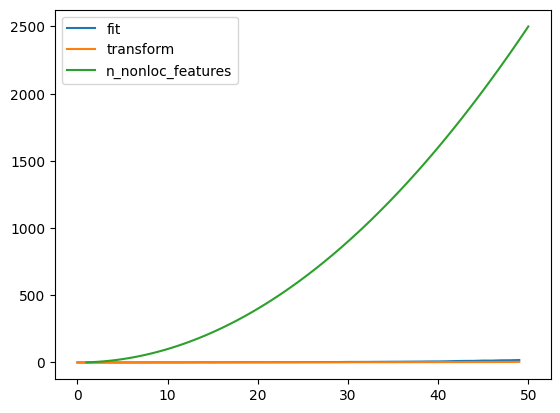

In [9]:
x = np.linspace(1, 50, 100)
y = x**2
plt.plot(fit_times, label="fit")
plt.plot(transform_times, label="transform")
plt.plot(x, y, label="n_nonloc_features")
plt.legend()
plt.savefig("runtime features.pdf",dpi=300)

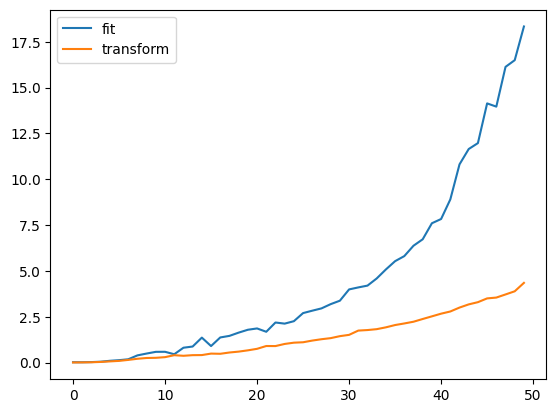

In [7]:
x = np.linspace(1, 50, 100)
y = x**2
plt.plot(fit_times, label="fit")
plt.plot(transform_times, label="transform")
plt.legend()
plt.savefig("runtime.pdf",dpi=300)